In [1]:
#importing the necessary libraries
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
csv_file_path = '/content/drive/MyDrive/Projects /colab et al/tb_labels.csv'

In [19]:
#x-rays
image_dir = '/content/drive/MyDrive/Projects /colab et al/TB_CXR_images'

In [20]:
#x-ray labels
data = pd.read_csv('/content/drive/MyDrive/Projects /colab et al/tb_labels.csv')

In [21]:
data.head()

,filename,label
0,MCUCXR_0001_0.png,0
1,MCUCXR_0002_0.png,0
2,MCUCXR_0003_0.png,0
3,MCUCXR_0004_0.png,0
4,MCUCXR_0005_0.png,0


In [23]:
#loop to extract the images and labels and add to lists
#where to store the images and the labels from the loaded data
image_paths = []
labels = []
for index, row in data.iterrows():
    filename = row['filename']
    label = row['label']

    #full path to the image
    img_path = os.path.join(image_dir, filename)

    # Check if the image file exists
    if os.path.exists(img_path):
        image_paths.append(img_path)
        labels.append(label)
print(len(labels))
print(len(image_paths))

135
135


In [24]:
# Split the data into training, validation, and test sets.
train_files, test_files, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.1, random_state=42)

In [25]:
# Display the number of samples in each set
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Test samples: {len(test_files)}")

Training samples: 97
Validation samples: 11
Test samples: 27


In [26]:
#Function to load and preprocess images
def load_and_preprocess_image(file_path, target_size=(224, 224)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, target_size)  # Resize the image to the target size
    img = img / 255.0  # Normalize pixel values between 0 and 1
    return img

In [27]:
# Example to load and preprocess an image
example_img = load_and_preprocess_image(train_files[0])
print(f"Example image shape: {example_img.shape}")

Example image shape: (224, 224, 3)


Correct format 224 by 224, RGB

In [28]:
# Preprocess all images in the training, validation, and test sets
X_train = np.array([load_and_preprocess_image(file) for file in train_files])
X_val = np.array([load_and_preprocess_image(file) for file in val_files])
X_test = np.array([load_and_preprocess_image(file) for file in test_files])

In [29]:
# Convert labels to np arrays
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [30]:
# We will save the preprocessed data to Drive
output_dir = '/content/drive/MyDrive/Projects/colab et al/processed_data/'
os.makedirs(output_dir, exist_ok=True)

# Save the processed data and labels as .npy files
np.save(output_dir + 'X_train.npy', X_train)
np.save(output_dir + 'X_val.npy', X_val)
np.save(output_dir + 'X_test.npy', X_test)

np.save(output_dir + 'y_train.npy', y_train)
np.save(output_dir + 'y_val.npy', y_val)
np.save(output_dir + 'y_test.npy', y_test)


In case we want to load the saved data later on.

In [31]:
"""
#To load the processed data from .npy files
loaded_X_train = np.load(output_dir + 'X_train.npy')
loaded_X_val = np.load(output_dir + 'X_val.npy')
loaded_X_test = np.load(output_dir + 'X_test.npy')

loaded_y_train = np.load(output_dir + 'y_train.npy')
loaded_y_val = np.load(output_dir + 'y_val.npy')
loaded_y_test = np.load(output_dir + 'y_test.npy')
"""

"\n#To load the processed data from .npy files\nloaded_X_train = np.load(output_dir + 'X_train.npy')\nloaded_X_val = np.load(output_dir + 'X_val.npy')\nloaded_X_test = np.load(output_dir + 'X_test.npy')\n\nloaded_y_train = np.load(output_dir + 'y_train.npy')\nloaded_y_val = np.load(output_dir + 'y_val.npy')\nloaded_y_test = np.load(output_dir + 'y_test.npy')\n"

Moving on to training the model after preprocessing the chest xray images

In [33]:
# importing the necessary keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [34]:
#The CNN
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [36]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
# Training the model on the images

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
4/4 [==============================] - 17s 3s/step - loss: 0.8127 - accuracy: 0.5258 - val_loss: 0.6948 - val_accuracy: 0.5455
Epoch 2/10
4/4 [==============================] - 14s 3s/step - loss: 0.6785 - accuracy: 0.5773 - val_loss: 0.7186 - val_accuracy: 0.5455
Epoch 3/10
4/4 [==============================] - 14s 3s/step - loss: 0.6783 - accuracy: 0.5979 - val_loss: 0.7360 - val_accuracy: 0.5455
Epoch 4/10
4/4 [==============================] - 12s 3s/step - loss: 0.6627 - accuracy: 0.5979 - val_loss: 0.7168 - val_accuracy: 0.5455
Epoch 5/10
4/4 [==============================] - 12s 3s/step - loss: 0.6511 - accuracy: 0.6082 - val_loss: 0.6860 - val_accuracy: 0.5455
Epoch 6/10
4/4 [==============================] - 14s 3s/step - loss: 0.5984 - accuracy: 0.6495 - val_loss: 0.6694 - val_accuracy: 0.5455
Epoch 7/10
4/4 [==============================] - 14s 3s/step - loss: 0.5919 - accuracy: 0.6907 - val_loss: 0.6686 - val_accuracy: 0.5455
Epoch 8/10
4/4 [==================

In [38]:
# Evaluate model on the set aside testing data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

1/1 [==============================] - 1s 1s/step - loss: 0.6444 - accuracy: 0.5926
Test Accuracy: 0.5925925970077515


59.26% accurate. Nowhere near good enough. Next step would be to use pretrained models instead of custom basic ones. Though this one could be improved by fine-tuning hyperparameters or performing transfer learning.

In [40]:
#saving the weights of the model
model_weights_path = '/content/drive/MyDrive/Projects/colab et al/keras_model_weights.h5'
model.save_weights(model_weights_path)


In [41]:
"""
# To load later on
# Define a model with the same architecture
model = Sequential()

# ... Architecture definition goes here ...

# Load
model.load_weights('/content/drive/MyDrive/Projects/colab et al/keras_model_weights.h5')

"""

"\n# To load later on\n# Define a model with the same architecture\nmodel = Sequential()\n\n# ... Architecture definition goes here ...\n\n# Load\nmodel.load_weights('/content/drive/MyDrive/Projects/colab et al/keras_model_weights.h5')\n\n"

We can visualise this with the matplotlib library tools. 📊

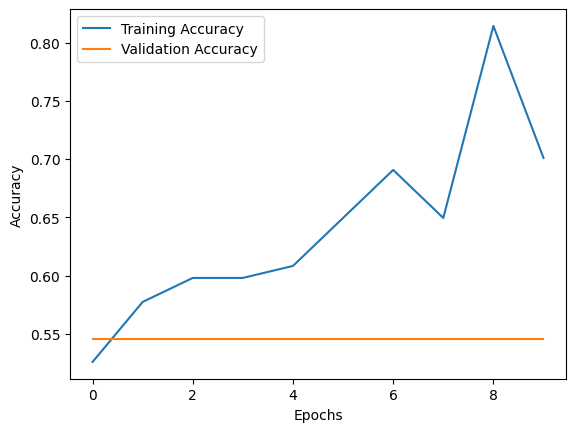

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


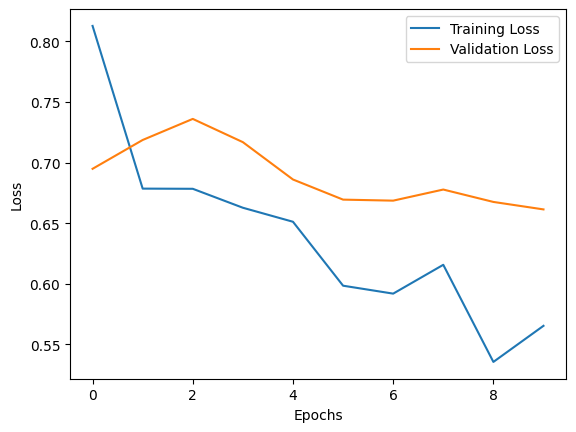

In [43]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()